In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
raw_covid = pd.read_csv("jrc-covid-19-world-latest.csv")
gini_data = pd.read_csv("gini_data2.csv")
gdp_data = pd.read_csv("gdp_data.csv")
pop_data = pd.read_csv("API_SP.POP.TOTL_DS2_en_csv_v2_2106202.csv")
pop_den = pd.read_csv("pop_density.csv")
unemploy_rates = pd.read_csv("unemployment_rates.csv")

In [3]:
gdp_data.columns = gdp_data.loc[3]
gdp_data = gdp_data.drop(index = [0,1,2,3])

In [4]:
new_colnames = [i.lower() for i in raw_covid.columns]
covid_cases = raw_covid.copy()
for i in covid_cases.columns:
    covid_cases.columns = new_colnames
    
#dropping unnecessary columns:
covid_cases = covid_cases[['date', 'iso3', 'continent', 'countryname'
                           , 'cumulativepositive', 'cumulativedeceased'
                           , 'currentlypositive']]
#renaming columns
covid_cases.rename(columns = {'iso3':'country_code','countryname':'country_name'
                              , 'cumulativepositive':'cumulative_pos', 'cumulativedeceased':'cumulative_dec'
                              , 'currentlypositive':'curr_pos'}, inplace = True)



#clean gdp data, drop unecessary columns and rename them
new_colnames = []
gdp = gdp_data.copy()
gdp.rename(columns = {"Country Name":"country_name","Country Code":"country_code",2019:"gdp_per_cap"}
           , inplace = True)
gdp = gdp[["country_name","country_code","gdp_per_cap"]]

#drop NaNs in gdp
gdp = gdp.dropna(axis = 0,subset=["gdp_per_cap"])

#clean gini column names
gini_data.rename(columns = {"Country Code":"country_code",
                          "Country":"country","Value":"gini_index",'Year':"gini_year"},inplace = True)

#clean population data
pop_data.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"population"}
                ,inplace = True)
pop_data = pop_data[["country_code",'country_name','population']]

#clean population density 
pop_den.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2018":"density"}
               ,inplace = True)
pop_den = pop_den[['country_code','country_name','density']]

#clean unemployment rates 
unemploy_rates.rename(columns = {"Country Code":"country_code","Country Name":"country_name","2019":"rates"}
                      ,inplace = True)
unemploy_rates = unemploy_rates[['country_code','country_name','rates']]


In [5]:
#adding gdp 
covid_gdp = pd.merge(left = covid_cases, right = gdp, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp))

#adding gini
covid_gdp_gini = pd.merge(left = covid_gdp, right = gini_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population 
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_data, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding population density
covid_gdp_gini = pd.merge(left = covid_gdp_gini, right = pop_den, left_on = "country_code",right_on = "country_code")
print(len(covid_gdp_gini))

#adding unemployment rates
covid_data = pd.merge(left = covid_gdp_gini, right = unemploy_rates, left_on = "country_code",right_on = "country_code")
print(len(covid_data))


#removing duplicate columns
covid_data = covid_data.drop(columns = ["country",'country_name_y',"country_name"])
covid_data.rename(columns = {"country_name_x":"country_name"},inplace = True)

166
140
140
136
136


In [77]:
#trying to get rid of strings that are in the unemployment columns 
for i in range(len(covid_data['unemploy_rates'])):
    if (type(covid_data['unemploy_rates'][i]) != float):
        covid_data = covid_data.drop(index = i)

In [6]:
covid_data['dec_pos_ratio'] = covid_data['cumulative_dec'] / covid_data['cumulative_pos']


In [8]:
covid_data.rename(columns = {'density':'pop_density', 'rates': 'unemploy_rates'}, inplace = True)
#covid_data.drop_duplicates(subset = 'country_name', keep = 'first', inplace = True)
covid_data.drop(labels = 'country_name', axis = 1, inplace = True)
covid_data.head()

,date,country_code,continent,cumulative_pos,cumulative_dec,curr_pos,gdp_per_cap,gini_index,gini_year,population,pop_density,unemploy_rates,dec_pos_ratio
0,2021-03-13,ALB,EU,116821,2030,34970.0,5353.244856,29.0,2012,2854191.0,104.6122628,11.47000027,0.017377
1,2021-02-15,DZA,AF,110711,2939,107772.0,3973.964072,27.6,2011,43053054.0,17.73006763,11.81000042,0.026547
2,2021-02-15,AGO,AF,20366,492,19874.0,2790.726615,42.7,2008,31825295.0,24.71305206,6.929999828,0.024158
3,2021-02-15,ARG,SA,2029008,50327,1978681.0,9912.281809,41.2,2017,44938712.0,16.2585101,9.840000153,0.024804
4,2021-02-15,AUS,OC,28900,909,27991.0,55060.326100,35.8,2014,25364307.0,3.24787091,5.159999847,0.031453


In [50]:
covid_data.columns

Index(['date', 'country_code', 'continent', 'country_name', 'cumulative_pos',
       'cumulative_dec', 'curr_pos', 'gdp_per_cap', 'gini_index', 'gini_year',
       'country_name', 'population', 'pop_density', 'unemploy_rates'],
      dtype='object')

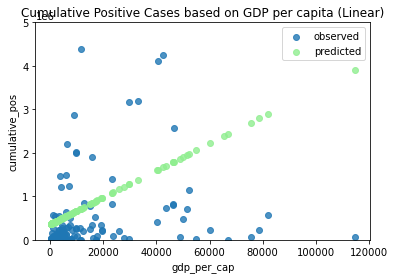

r^2: 0.00


In [21]:
#predict cumulative_positive covid cases (Y) based on gdp_per_cap (X) -- Linear Regression

pos_gdp_regressor = LinearRegression()

pos_gdp_reshapeX = np.reshape(covid_data[['gdp_per_cap']], (-1, 1))


pos_gdp_regressor.fit(pos_gdp_reshapeX, covid_data['cumulative_pos'])

pos_gdp_pred = pos_gdp_regressor.predict(pos_gdp_reshapeX)

plt.scatter(pos_gdp_reshapeX, covid_data['cumulative_pos'], alpha = 0.8)
plt.scatter(pos_gdp_reshapeX, pos_gdp_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on GDP per capita (Linear)')
plt.xlabel('gdp_per_cap')
plt.ylabel('cumulative_pos')
plt.legend(['observed', 'predicted'])

plt.ylim(0, 5000000)
plt.show()


score_gdp = pos_gini_regressor.score(covid_data[['gini_index']], covid_data['cumulative_pos'])

print("r^2: {:.2f}".format(score_gdp))



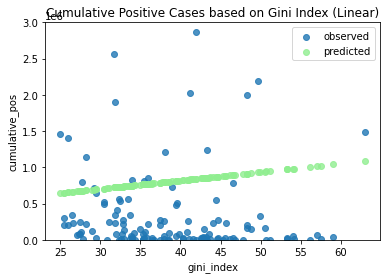

r^2: 0.00


In [20]:
#predict cumulative_positive covid cases (Y) based on gini_index (X) -- Linear Regression

pos_gini_regressor = LinearRegression()

pos_gini_reshapeX = np.reshape(covid_data[['gini_index']], (-1, 1))


pos_gini_regressor.fit(pos_gini_reshapeX, covid_data['cumulative_pos'])

pos_gini_pred = pos_gini_regressor.predict(pos_gini_reshapeX)

plt.scatter(pos_gini_reshapeX, covid_data['cumulative_pos'], alpha = 0.8)
plt.scatter(pos_gini_reshapeX, pos_gini_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Gini Index (Linear)')
plt.xlabel('gini_index')
plt.ylabel('cumulative_pos')
plt.legend(['observed', 'predicted'])

plt.ylim(0, 3000000)
plt.show()

score_gini = pos_gini_regressor.score(covid_data[['gini_index']], covid_data['cumulative_pos'])

print("r^2: {:.2f}".format(score_gini))


TypeError: unhashable type: 'numpy.ndarray'

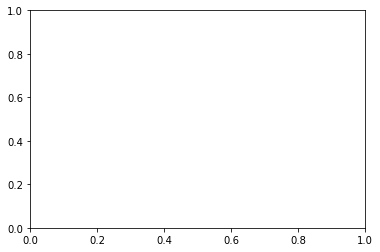

In [73]:
#predict cumulative_positive covid cases (Y) based on population density (X) -- Linear Regression

pos_den_regressor = LinearRegression()

pos_den_reshapeX = np.reshape((covid_data[['pop_density']]), (-1, 1))

#pos_den_reshapeX = tuple(pos_den_reshapeX)

pos_den_regressor.fit(pos_den_reshapeX, covid_data['cumulative_pos'])

pos_den_pred = pos_den_regressor.predict(pos_den_reshapeX)

plt.scatter(pos_den_reshapeX, covid_data['cumulative_pos'], alpha = 0.8)
plt.scatter(pos_den_reshapeX, pos_den_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Population Density (Linear)')
plt.xlabel('pop_den')
plt.ylabel('cumulative_pos')
plt.legend(['observed', 'predicted'])

#plt.ylim(0, 3000000)

plt.show()


In [53]:
#predict cumulative_positive covid cases (Y) based on unemployment rates (X) -- Linear Regression

pos_rates_regressor = LinearRegression()

pos_rates_reshapeX = np.reshape(covid_data[['unemploy_rates']], (-1, 1))

#pos_den_reshapeX = tuple(pos_den_reshapeX)

pos_rates_regressor.fit(pos_rates_reshapeX, covid_data['cumulative_pos'])

pos_rates_pred = pos_rates_regressor.predict(pos_rates_reshapeX)

plt.scatter(pos_rates_reshapeX, covid_data['cumulative_pos'], alpha = 0.8)
plt.scatter(pos_rates_reshapeX, pos_rates_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Unemployment Rates (Linear)')
plt.xlabel('unemploy_rates')
plt.ylabel('cumulative_pos')
plt.legend(['observed', 'predicted'])

#plt.ylim(0, 3000000)

plt.show()


ValueError: could not convert string to float: '*'

In [18]:
#multi model :  predict cumulative pos based on gdp and gini
multi_model = LinearRegression()
multi_model.fit(covid_data[['gdp_per_cap', 'gini_index']], covid_data['cumulative_pos'])
print('gdp_per_cap coefficient: ', multi_model.coef_[0])
print('gini_index coefficient: ', multi_model.coef_[1])

score = multi_model.score(covid_data[['gdp_per_cap', 'gini_index']], covid_data['cumulative_pos'])
print("r^2: {:.2f}".format(score))

plt.show()

gdp_per_cap coefficient:  37.51650195667505
gini_index coefficient:  44924.36117088157
r^2: 0.07


In [ ]:
# #predict ratio covid cases (Y) based on gdp (X) -- Linear Regression

# ratio_regressor = LinearRegression()

# ratio_reshapeX = np.reshape(covid_data[['dec_pos_ratio']], (-1, 1))


# ratio_regressor.fit(ratio_reshapeX, covid_data['cumulative_pos'])

# ratio_pred = ratio_regressor.predict(ratio_reshapeX)

# plt.scatter(ratio_reshapeX, covid_data['cumulative_pos'], alpha = 0.8)
# plt.scatter(ratio_reshapeX, ratio_pred, c ='lightgreen', alpha = 0.8)
# plt.title('Cumulative Positive Cases based on Ratio (Linear)')
# plt.xlabel('gini_index')
# plt.ylabel('cumulative_pos')
# plt.legend(['observed', 'predicted'])

# plt.ylim(0, 3000000)

# plt.show()

In [17]:
#multi model :  predict dec/pos ratio based on gdp and gini
multi_model_ratio = LinearRegression()
multi_model_ratio.fit(covid_data[['gdp_per_cap', 'gini_index']], covid_data['dec_pos_ratio'])
# print('gdp_per_cap coefficient: ', multi_model.coef_[0])
# print('gini_index coefficient: ', multi_model.coef_[1])

score_ratio = multi_model_ratio.score(covid_data[['gdp_per_cap', 'gini_index']], covid_data['dec_pos_ratio'])
print("r^2: {:.2f}".format(score_ratio))

#plt.show()

r^2: 0.01


In [16]:
#multi model :  predict cumulative dec based on gdp and gini
multi_model_dec = LinearRegression()
multi_model_dec.fit(covid_data[['gdp_per_cap', 'gini_index']], covid_data['cumulative_dec'])
# print('gdp_per_cap coefficient: ', multi_model.coef_[0])
# print('gini_index coefficient: ', multi_model.coef_[1])

score_dec = multi_model_dec.score(covid_data[['gdp_per_cap', 'gini_index']], covid_data['cumulative_dec'])
print("r^2: {:.2f}".format(score_dec))

#plt.show()

r^2: 0.08


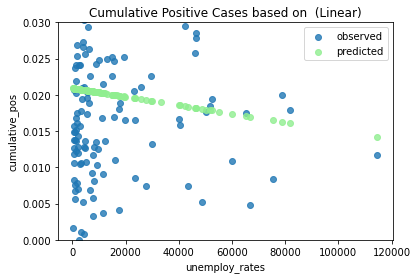

r^2: 0.01


In [15]:
#predict ratio (Y) based on gdp_per_cap (X) -- Linear Regression

ratio_gdp_regressor = LinearRegression()

ratio_gdp_reshapeX = np.reshape(covid_data[['gdp_per_cap']], (-1, 1))

#pos_den_reshapeX = tuple(pos_den_reshapeX)

ratio_gdp_regressor.fit(ratio_gdp_reshapeX, covid_data['dec_pos_ratio'])

ratio_gdp_pred = ratio_gdp_regressor.predict(ratio_gdp_reshapeX)

plt.scatter(ratio_gdp_reshapeX, covid_data['dec_pos_ratio'], alpha = 0.8)
plt.scatter(ratio_gdp_reshapeX, ratio_gdp_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on  (Linear)')
plt.xlabel('unemploy_rates')
plt.ylabel('cumulative_pos')
plt.legend(['observed', 'predicted'])

plt.ylim(0, 0.03)

plt.show()

score_r2 = ratio_gdp_regressor.score(covid_data[['gdp_per_cap']], covid_data['dec_pos_ratio'])
print("r^2: {:.2f}".format(score_r2))

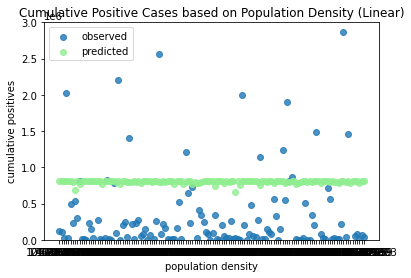

r squared: 0.00


In [10]:
#predict cumulative_positive covid cases (Y) based on population density (X) -- Linear Regression

pos_den_regressor = LinearRegression()

pos_den_regressor.fit(covid_data[['pop_density']], covid_data['cumulative_pos'])

pos_den_pred = pos_den_regressor.predict(covid_data[['pop_density']])

%matplotlib inline
plt.scatter(covid_data['pop_density'], covid_data['cumulative_pos'], alpha = 0.8)
plt.scatter(covid_data['pop_density'], pos_den_pred, c ='lightgreen', alpha = 0.8)
plt.title('Cumulative Positive Cases based on Population Density (Linear)')
plt.xlabel('population density')
plt.ylabel('cumulative positives')
plt.legend(['observed', 'predicted'])
plt.ylim(0, 3000000)

plt.show()
print("r squared: {:.2f}".format(pos_den_regressor.score(covid_data[['pop_density']], covid_data['cumulative_pos'])))


In [ ]:
#multi model :  predict cumulative dec based on gdp and gini and pop density
multi_model_pop = LinearRegression()
multi_model_pop.fit(covid_data[['gdp_per_cap', 'gini_index', ]], covid_data['cumulative_dec'])
# print('gdp_per_cap coefficient: ', multi_model.coef_[0])
# print('gini_index coefficient: ', multi_model.coef_[1])

score_dec = multi_model_dec.score(covid_data[['gdp_per_cap', 'gini_index']], covid_data['cumulative_dec'])
print('r^2 score: ', score_dec)

#plt.show()